In [1]:
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.datasets import load_boston
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, validation_curve, learning_curve, GridSearchCV
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from yellowbrick.model_selection import ValidationCurve, LearningCurve

In [2]:
%matplotlib inline
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

## Get the Data

### Kings County Housing Data

Data from [Kaggle](https://www.kaggle.com/harlfoxem/housesalesprediction)

Download via API:

```kaggle datasets download -d harlfoxem/housesalesprediction```

In [3]:
DATA_PATH = Path('..', '..', 'data')

In [4]:
house_sales = pd.read_csv(DATA_PATH / 'kc_house_data.csv')
house_sales = house_sales.drop(
    ['id', 'zipcode', 'lat', 'long', 'date'], axis=1)
house_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 16 columns):
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(3), int64(13)
memory usage: 2.6 MB


## Select & Transform Features

### Asset Prices often have long tails

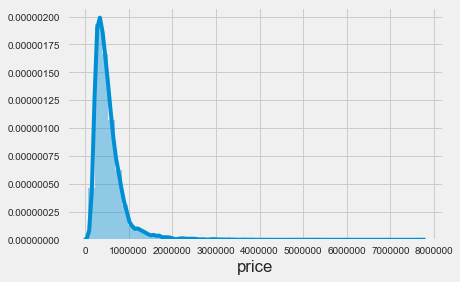

In [5]:
sns.distplot(house_sales.price);

### Use log-transform

In [6]:
X_all = house_sales.drop('price', axis=1)
y = np.log(house_sales.price)

### Mutual information regression

In [7]:
mi_reg = pd.Series(mutual_info_regression(X_all, y),
                   index=X_all.columns).sort_values(ascending=False)
mi_reg

sqft_living      0.347869
grade            0.344562
sqft_living15    0.270071
sqft_above       0.258919
bathrooms        0.205687
sqft_lot15       0.084961
bedrooms         0.080456
floors           0.078557
yr_built         0.074420
sqft_basement    0.066095
sqft_lot         0.060936
view             0.054255
waterfront       0.012395
yr_renovated     0.012091
condition        0.011701
dtype: float64

In [8]:
X = X_all.loc[:, mi_reg.iloc[:10].index]

### Bivariate Scatter Plots

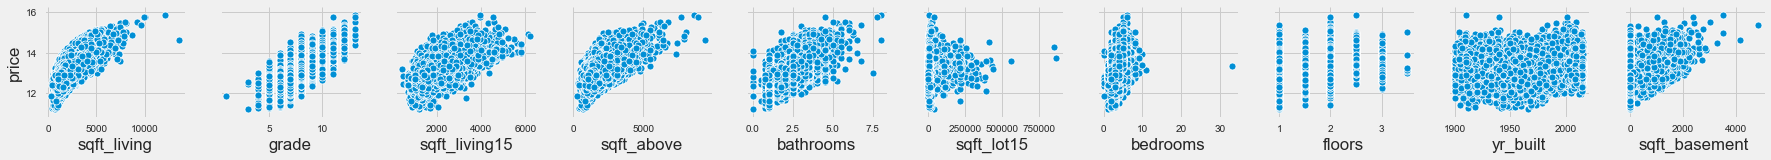

In [9]:
sns.pairplot(X.assign(price=y), y_vars=['price'], x_vars=X.columns);

### Explore Correlations

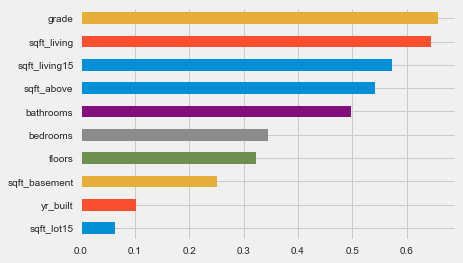

In [10]:
correl = (X
          .apply(lambda x: spearmanr(x, y))
          .apply(pd.Series, index=['r', 'pval']))

correl.r.sort_values().plot.barh();

## KNN Regression

### In-sample performance with default settings

KNN uses distance to make predictions; it requires standardization of variables to avoid undue influence based on scale

In [11]:
X_scaled = scale(X)

In [12]:
model = KNeighborsRegressor()
model.fit(X=X_scaled, y=y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

In [13]:
y_pred = model.predict(X_scaled)

### Regression Error Metrics

In [14]:
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             mean_squared_log_error, 
                             median_absolute_error, 
                             explained_variance_score, 
                             r2_score)

#### Computing the prediction error

The error is the deviation from the true value, whereas a residual is the deviation from an estimated value, e.g., an estimate of the population mean.

In [15]:
error = (y - y_pred).rename('Prediction Errors')

In [16]:
scores = dict(
    rmse=np.sqrt(mean_squared_error(y_true=y, y_pred=y_pred)),
    rmsle=np.sqrt(mean_squared_log_error(y_true=y, y_pred=y_pred)),
    mean_ae=mean_absolute_error(y_true=y, y_pred=y_pred),
    median_ae=median_absolute_error(y_true=y, y_pred=y_pred),
    r2score=explained_variance_score(y_true=y, y_pred=y_pred)
)

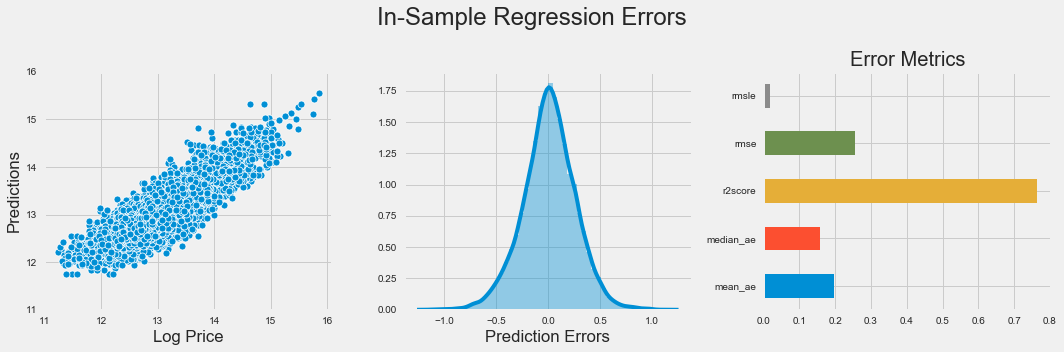

In [17]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
sns.scatterplot(x=y, y=y_pred, ax=axes[0])
axes[0].set_xlabel('Log Price')
axes[0].set_ylabel('Predictions')
axes[0].set_ylim(11, 16)
sns.distplot(error, ax=axes[1])
pd.Series(scores).plot.barh(ax=axes[2], title='Error Metrics')
fig.suptitle('In-Sample Regression Errors', fontsize=24)
fig.tight_layout()
plt.subplots_adjust(top=.8);

### Cross-Validation

Manual hyperparameter tuning; using Pipeline to ensure proper scaling for each fold using train metrics to standardize test data.

In [18]:
def rmse(y_true, pred):
    return np.sqrt(mean_squared_error(y_true=y_true, y_pred=pred))

rmse_score = make_scorer(rmse)

In [22]:
cv_rmse = {}
n_neighbors = [1] + list(range(5, 51, 5))
for n in n_neighbors:
    pipe = Pipeline([('scaler', StandardScaler()),
                     ('knn', KNeighborsRegressor(n_neighbors=n))])                    
    cv_rmse[n] = cross_val_score(pipe, 
                                X=X, 
                                y=y,
                                scoring=rmse_score,
                                cv=5)

In [23]:
cv_rmse = pd.DataFrame.from_dict(cv_rmse, orient='index')
best_n, best_rmse = cv_rmse.mean(1).idxmin(), cv_rmse.mean(1).min()
cv_rmse = cv_rmse.stack().reset_index()
cv_rmse.columns =['n', 'fold', 'RMSE']

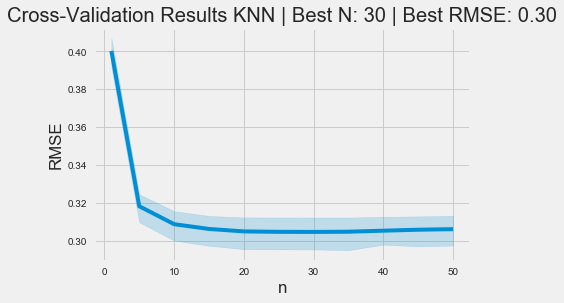

In [24]:
ax = sns.lineplot(x='n', y='RMSE', data=cv_rmse)
ax.set_title(f'Cross-Validation Results KNN | Best N: {best_n:d} | Best RMSE: {best_rmse:.2f}');

#### Actuals vs Predicted

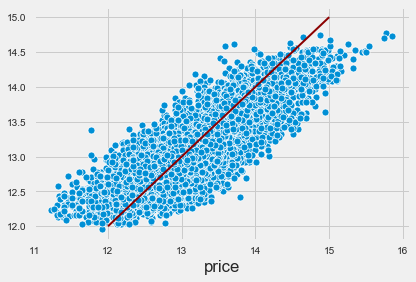

In [25]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('knn', KNeighborsRegressor(n_neighbors=best_n))])
y_pred = cross_val_predict(pipe, X, y, cv=5)

ax = sns.scatterplot(x=y, y=y_pred)
y_range = list(range(int(y.min() + 1), int(y.max() + 1)))
pd.Series(y_range, index=y_range).plot(ax=ax, lw=2, c='darkred');

#### Cross-Validation Errors

In [26]:
error = (y - y_pred).rename('Prediction Errors')

In [27]:
scores = dict(
    rmse=np.sqrt(mean_squared_error(y_true=y, y_pred=y_pred)),
    rmsle=np.sqrt(mean_squared_log_error(y_true=y, y_pred=y_pred)),
    mean_ae=mean_absolute_error(y_true=y, y_pred=y_pred),
    median_ae=median_absolute_error(y_true=y, y_pred=y_pred),
    r2score=explained_variance_score(y_true=y, y_pred=y_pred)
)

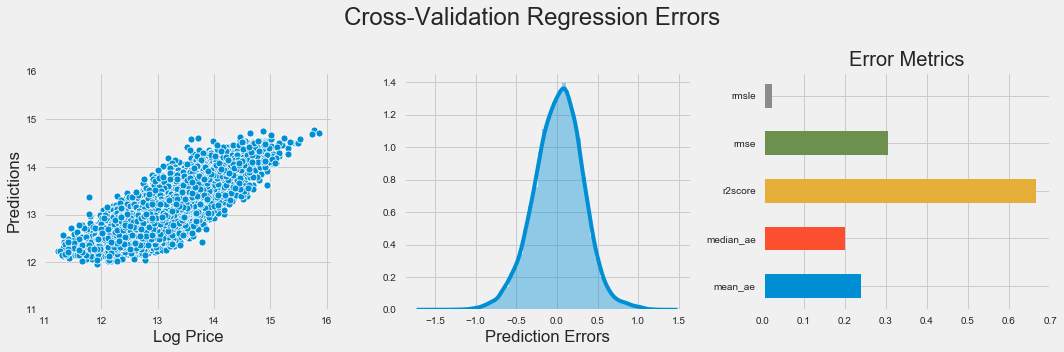

In [28]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
sns.scatterplot(x=y, y=y_pred, ax=axes[0])
axes[0].set_xlabel('Log Price')
axes[0].set_ylabel('Predictions')
axes[0].set_ylim(11, 16)
sns.distplot(error, ax=axes[1])
pd.Series(scores).plot.barh(ax=axes[2], title='Error Metrics')
fig.suptitle('Cross-Validation Regression Errors', fontsize=24)
fig.tight_layout()
plt.subplots_adjust(top=.8);

### GridSearchCV with Pipeline

In [30]:
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('knn', KNeighborsRegressor())])

n_folds = 5
n_neighbors = tuple(range(5, 101, 5))

param_grid = {'knn__n_neighbors': n_neighbors}

estimator = GridSearchCV(estimator=pipe,
                         param_grid=param_grid,
                         cv=n_folds,
                         scoring=rmse_score,
#                          n_jobs=-1
                        )
estimator.fit(X=X, y=y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'knn__n_neighbors': (5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(rmse), verbose=0)

In [31]:
cv_results = estimator.cv_results_

In [32]:
test_scores = pd.DataFrame({fold: cv_results[f'split{fold}_test_score'] for fold in range(n_folds)}, 
                           index=n_neighbors).stack().reset_index()
test_scores.columns = ['k', 'fold', 'RMSE']

In [33]:
mean_rmse = test_scores.groupby('k').RMSE.mean()
best_k, best_score = mean_rmse.idxmin(), mean_rmse.min()

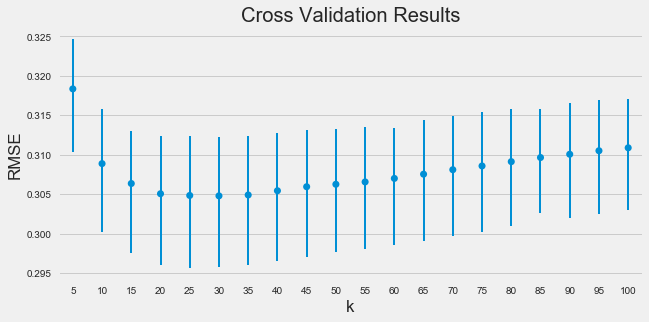

In [34]:
sns.pointplot(x='k', y='RMSE', data=test_scores, scale=.3, join=False, errwidth=2)
plt.title('Cross Validation Results')
plt.tight_layout()
plt.gcf().set_size_inches(10, 5);

### Train & Validation Curves mit yellowbricks


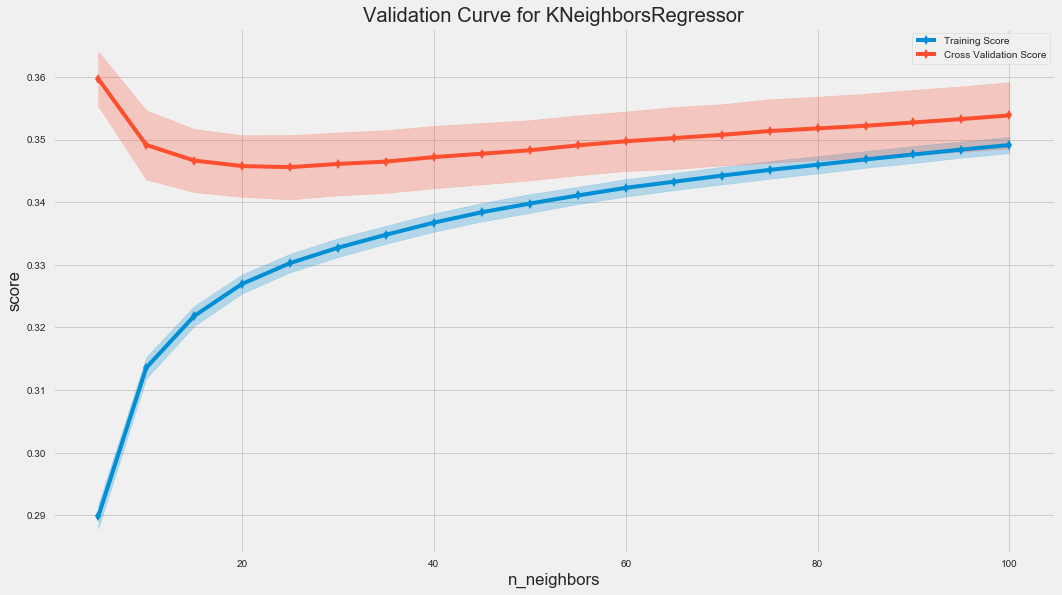

In [35]:
fig, ax = plt.subplots(figsize=(16, 9))
val_curve = ValidationCurve(KNeighborsRegressor(),
                      param_name='n_neighbors',
                      param_range=n_neighbors,
                      cv=5,
                      scoring=rmse_score,
#                       n_jobs=-1,
                      ax=ax)
val_curve.fit(X, y)
val_curve.poof()
fig.tight_layout();

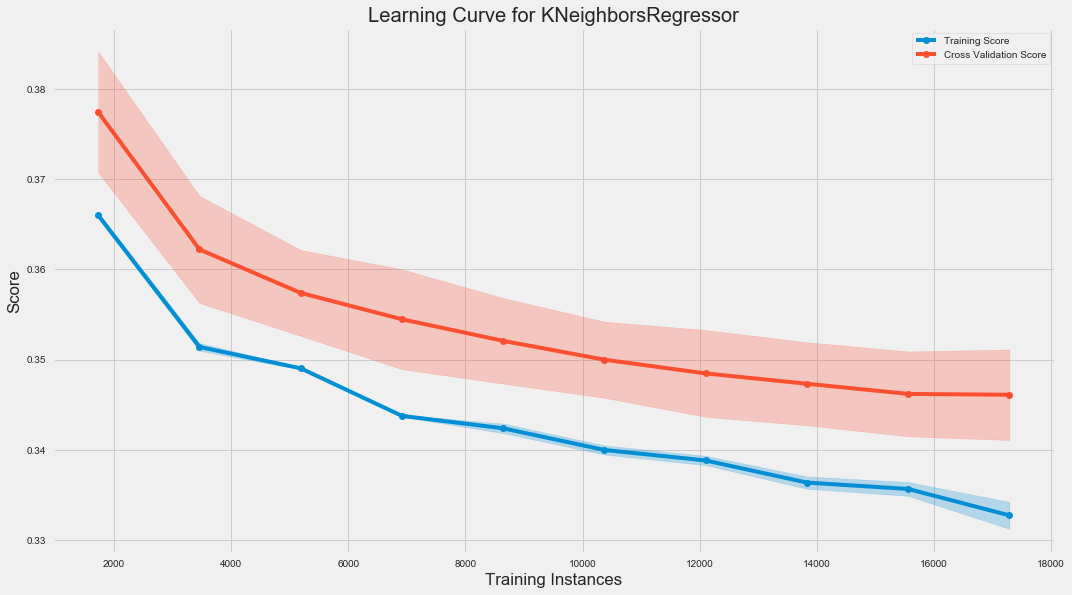

In [36]:
fig, ax = plt.subplots(figsize=(16, 9))
l_curve = LearningCurve(KNeighborsRegressor(n_neighbors=best_k), 
                        train_sizes=np.arange(.1, 1.01, .1),
                        scoring=rmse_score, 
                        cv=5, 
#                         n_jobs=-1,
                        ax=ax)
l_curve.fit(X, y)
l_curve.poof()
fig.tight_layout();

## Binary Classification

In [37]:
y_binary = (y>y.median()).astype(int)

In [38]:
n_neighbors = tuple(range(5, 151, 10))
n_folds = 5
scoring = 'roc_auc'

In [39]:
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('knn', KNeighborsClassifier())])

param_grid = {'knn__n_neighbors': n_neighbors}

estimator = GridSearchCV(estimator=pipe,
                         param_grid=param_grid,
                         cv=n_folds,
                         scoring=scoring,
#                          n_jobs=-1
                        )
estimator.fit(X=X, y=y_binary)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'knn__n_neighbors': (5, 15, 25, 35, 45, 55, 65, 75, 85, 95, 105, 115, 125, 135, 145)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [40]:
best_k = estimator.best_params_['knn__n_neighbors']

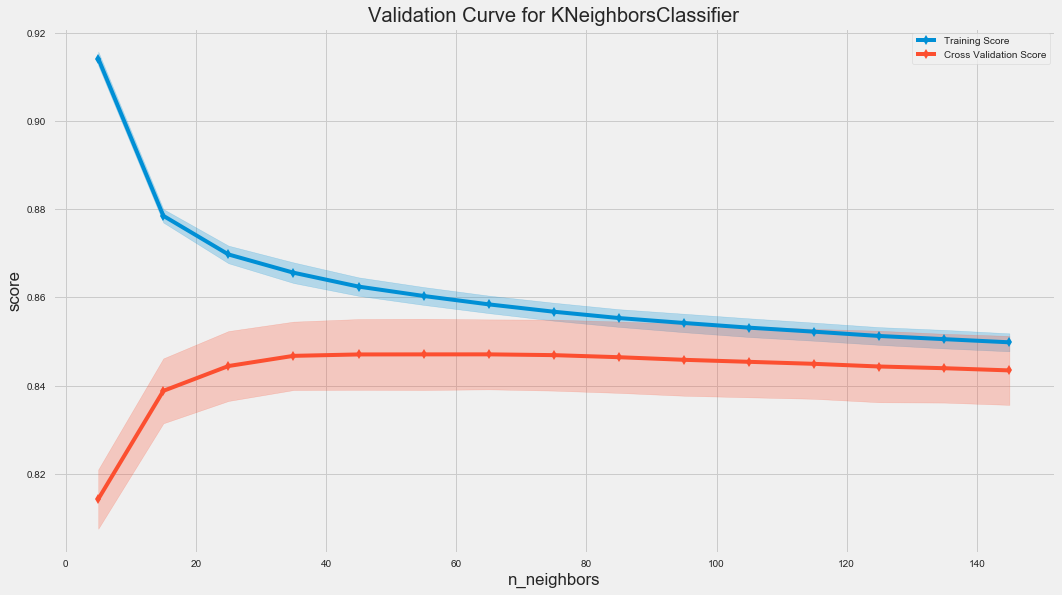

In [41]:
fig, ax = plt.subplots(figsize=(16, 9))
val_curve = ValidationCurve(KNeighborsClassifier(),
                      param_name='n_neighbors',
                      param_range=n_neighbors,
                      cv=n_folds,
                      scoring=scoring,
#                       n_jobs=-1,
                      ax=ax)
val_curve.fit(X, y_binary)
val_curve.poof()
fig.tight_layout();

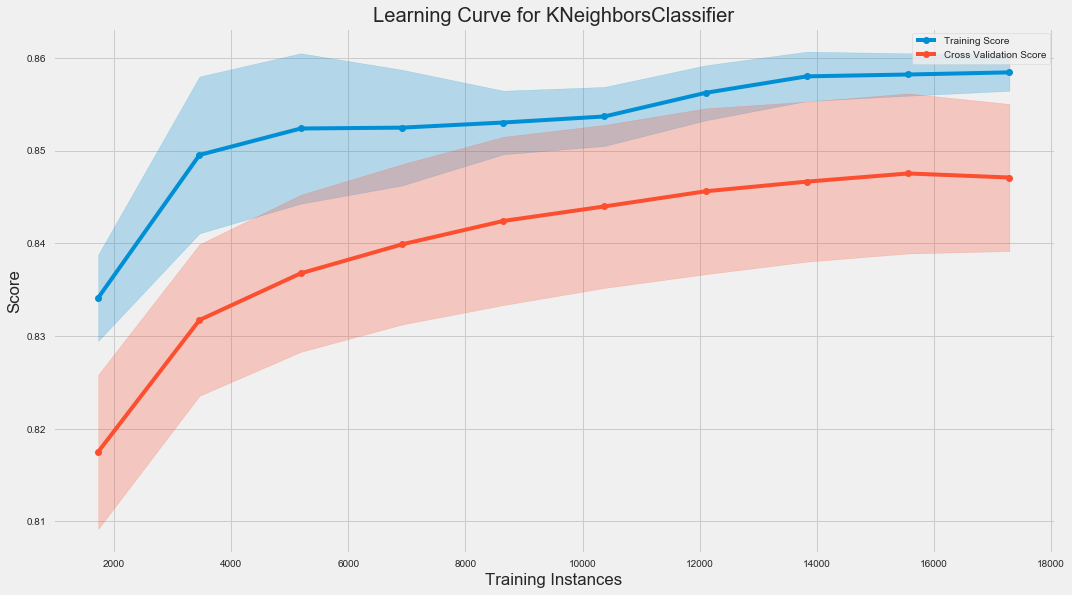

In [42]:
fig, ax = plt.subplots(figsize=(16, 9))
l_curve = LearningCurve(KNeighborsClassifier(n_neighbors=best_k), 
                        train_sizes=np.arange(.1, 1.01, .1),
                        scoring=scoring, 
                        cv=5, 
#                         n_jobs=-1,
                        ax=ax)
l_curve.fit(X, y_binary)
l_curve.poof()
fig.tight_layout();

### Classification Metrics

In [43]:
from sklearn.metrics import (classification_report,
                             accuracy_score,
                             zero_one_loss,
                             auc,
                             roc_auc_score,
                             roc_curve,
                             brier_score_loss,
                             cohen_kappa_score,
                             confusion_matrix,
                             fbeta_score,
                             hamming_loss,
                             hinge_loss,
                             jaccard_similarity_score,
                             log_loss,
                             matthews_corrcoef,
                             f1_score,
                             precision_recall_fscore_support,
                             average_precision_score,
                             precision_recall_curve,
                             precision_score,
                             recall_score)

|Name| API|
|:----|----|
|Area Under the Receiver Operating Characteristic Curve (ROC AUC) | roc_auc_score(y_true, y_score[, …])|
|Receiver operating characteristic (ROC) | roc_curve(y_true, y_score[, …])|
|Average precision (AP) | average_precision_score(y_true, y_score)|
|Precision-recall pairs | precision_recall_curve(y_true, …)|
|Precision, recall, F-measure and support | precision_recall_fscore_support(…)|
|F1 Score | f1_score(y_true, y_pred[, labels, …])|
|F-beta Score | fbeta_score(y_true, y_pred, beta[, …])|
|Precision | precision_score(y_true, y_pred[, …]|
|Recall | recall_score(y_true, y_pred[, …])|
|Main classification metrics | classification_report(y_true, y_pred)|
|confusion matrix | confusion_matrix(y_true, y_pred[, …])|
|Accuracy classification score | accuracy_score(y_true, y_pred)|
|Zero-one classification loss | zero_one_loss(y_true, y_pred[, …])|
|Average Hamming loss | hamming_loss(y_true, y_pred[, …])|
|Brier score | brier_score_loss(y_true, y_prob[, …])|
|Cohen’s kappa | cohen_kappa_score(y1, y2[, labels, …])|
|Average hinge loss | hinge_loss(y_true, pred_decision[, …])|
|Jaccard similarity coefficient | jaccard_similarity_score(y_true, y_pred)|
|Log loss, aka logistic loss or cross-entropy loss | log_loss(y_true, y_pred[, eps, …])|
|Matthews correlation coefficient (MCC) | matthews_corrcoef(y_true, y_pred[, …])|

In [44]:
y_score = cross_val_predict(KNeighborsClassifier(best_k), 
                           X=X, 
                           y=y_binary, 
                           cv=5, 
#                            n_jobs=-1, 
                           method='predict_proba')[:, 1]

#### Using Predicted Probabilities

In [46]:
pred_scores = dict(y_true=y_binary,y_score=y_score)

##### ROC AUC

In [47]:
roc_auc_score(**pred_scores)

0.8460203973490154

In [48]:
cols = ['False Positive Rate', 'True Positive Rate', 'threshold']
roc = pd.DataFrame(dict(zip(cols, roc_curve(**pred_scores))))

##### Precision-Recall

In [49]:
precision, recall, ts = precision_recall_curve(y_true=y_binary, probas_pred=y_score)
pr_curve = pd.DataFrame({'Precision': precision, 'Recall': recall})

##### F1 Score - Optimize Threshold

In [52]:
f1 = pd.Series({t: f1_score(y_true=y_binary, y_pred=y_score>t) for t in ts})
best_threshold = f1.idxmax()

##### Plot

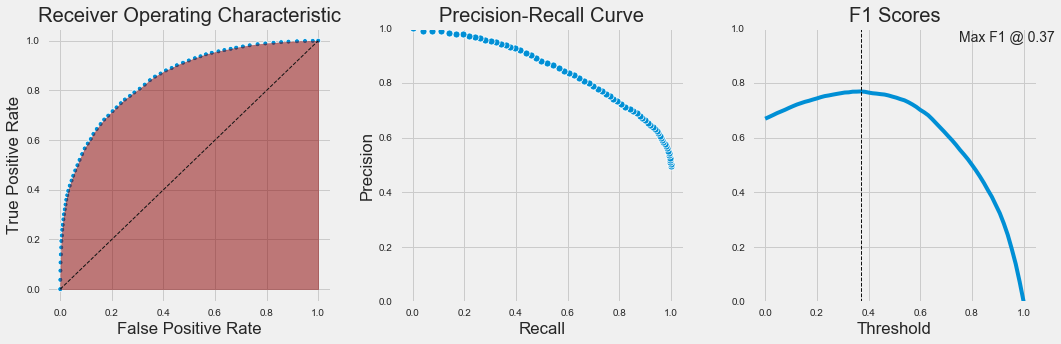

In [53]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

ax = sns.scatterplot(x='False Positive Rate', y='True Positive Rate', data=roc, size=5, legend=False, ax=axes[0])
axes[0].plot(np.linspace(0,1,100), np.linspace(0,1,100), color='k', ls='--', lw=1)
axes[0].fill_between(y1=roc['True Positive Rate'], x=roc['False Positive Rate'], alpha=.5,color='darkred')
axes[0].set_title('Receiver Operating Characteristic')


sns.scatterplot(x='Recall', y='Precision', data=pr_curve, ax=axes[1])
axes[1].set_ylim(0,1)
axes[1].set_title('Precision-Recall Curve')


f1.plot(ax=axes[2], title='F1 Scores', ylim=(0,1))
axes[2].set_xlabel('Threshold')
axes[2].axvline(best_threshold, lw=1, ls='--', color='k')
axes[2].text(text=f'Max F1 @ {best_threshold:.2f}', x=.75, y=.95, s=5)
fig.tight_layout();

##### Average Precision

In [54]:
average_precision_score(y_true=y_binary, y_score=y_score)

0.8484062482212291

##### Brier Score

In [55]:
brier_score_loss(y_true=y_binary, y_prob=y_score)

0.16022915202525762

#### Use Predictions after thresholding

In [56]:
y_pred = y_score > best_threshold

In [57]:
scores = dict(y_true=y_binary, y_pred=y_pred)

##### F-beta Score

In [58]:
fbeta_score(**scores, beta=1)

0.768433805405857

In [59]:
print(classification_report(**scores))

              precision    recall  f1-score   support

           0       0.82      0.63      0.71     10864
           1       0.70      0.86      0.77     10749

   micro avg       0.74      0.74      0.74     21613
   macro avg       0.76      0.74      0.74     21613
weighted avg       0.76      0.74      0.74     21613



##### Confusion Matrix

In [60]:
confusion_matrix(**scores)

array([[6873, 3991],
       [1552, 9197]])

##### Accuracy

In [61]:
accuracy_score(**scores)

0.7435339841761902

##### Zero-One Loss

In [62]:
zero_one_loss(**scores)

0.2564660158238098

##### Hamming Loss

Fraction of labels that are incorrectly predicted

In [63]:
hamming_loss(**scores)

0.25646601582380973

##### Cohen's Kappa

Score that expresses the level of agreement between two annotators on a classification problem.

In [64]:
cohen_kappa_score(y1=y_binary, y2=y_pred)

0.4876687258259045

##### Hinge Loss

In [65]:
hinge_loss(y_true=y_binary, pred_decision=y_pred)

0.7591264516726044

##### Jaccard Similarity

In [66]:
jaccard_similarity_score(**scores)

0.7435339841761902

##### Log Loss / Cross Entropy Loss

In [67]:
log_loss(**scores)

8.858170025000408

##### Matthews Correlation Coefficient

In [68]:
matthews_corrcoef(**scores)

0.5005536590342685

## Multi-Class

In [69]:
y_multi = pd.qcut(y, q=3, labels=[0,1,2])

In [70]:
n_neighbors = tuple(range(5, 151, 10))
n_folds = 5
scoring = 'accuracy'

In [71]:
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('knn', KNeighborsClassifier())])

param_grid = {'knn__n_neighbors': n_neighbors}

estimator = GridSearchCV(estimator=pipe,
                         param_grid=param_grid,
                         cv=n_folds,
#                          n_jobs=-1
                        )
estimator.fit(X=X, y=y_multi)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'knn__n_neighbors': (5, 15, 25, 35, 45, 55, 65, 75, 85, 95, 105, 115, 125, 135, 145)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [72]:
y_pred = cross_val_predict(estimator.best_estimator_, 
                           X=X, 
                           y=y_multi, 
                           cv=5, 
#                            n_jobs=-1, 
                           method='predict')

In [73]:
print(classification_report(y_true=y_multi, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.67      0.71      0.69      7226
           1       0.52      0.52      0.52      7223
           2       0.77      0.74      0.75      7164

   micro avg       0.65      0.65      0.65     21613
   macro avg       0.65      0.65      0.65     21613
weighted avg       0.65      0.65      0.65     21613

